# Accessing ITS_LIVE data via S3 bucket

This notebook will demonstrate how to access cloud-hosted Inter-mission Time Series of Land Ice Velocity and Elevation (ITS_LIVE) data from AWS S3 buckets. Here you will find examples of how to successfully access cloud-hosted data as well as some common errors and issues you may run into along the way, what they mean, and how to resolve them. 

Learning goals:
- accessing and inspecting data stored in s3 buckets 


Notes
- looks like some (at least 1?) HMA granule is working now
- let's try to explore the different 32645 granules, see what is available and what their spatial coverage/relationship is

## 6/11 still to add
- further refine the filtering options at the json catalog stage? 
    - would be nice to give x and y bounds (or maybe better in degrees?) to narrow it down at a first pass by more than just epsg code
 - get_bbox() should show something about the granule id/location as a text printout ideally as well
 - maybe show a basic beginning example of looking at a single scene, plotting a few different time steps to show variability in coverage

In [2]:
import geopandas as gpd
import os
import numpy as np
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
#from geocube.api.core import make_geocube
from shapely.geometry import Polygon
import cartopy.crs as ccrs

import cartopy
import cartopy.feature as cfeature
import json

## Finding / selecting data

The ITS_LIVE project details a number of data access options on their [website](https://its-live.jpl.nasa.gov/#access). Here, we will be accessing ITS_LIVE data in the form of `zarr` data cubes that are stored in **s3 buckets** hosted by Amazon Web Services (AWS). 

Let's begin by looking at the [GeoJSON Data Cubes Catalog](https://its-live-data.s3.amazonaws.com/datacubes/catalog_v02.json). 
This catalog contains spatial information and properties of ITS_LIVE data cubes as well as the url used to access each cube. Let's take a look at the entry for a single data cube and the information that it contains:

![itslive_info](images/screengrab_itslive_catalog_entry.png)

The top portion of the picture shows the spatial extent of the data cube in lat/lon units. Below that, we have properties such as the epsg code of the coordinate reference system, the spatial footprint in projected units and the url of the zarr object. 

Let's take a look at the url more in-depth: 

![itslive_url](images/itslive_url.png)

From this link we can see that we are looking at its_live data located in an s3 bucket hosted by amazon AWS. We cans see that we're looking in the data cube directory and what seems to be version 2. The next bit gives us information about the global location of the cube (N40E080). The actual file name `ITS_LIVE_vel_EPSG32645_G0120_X250000_Y4750000.zarr` tells us that we are looking at ice velocity data (its_live also has elevation data), in the CRS associated with EPSG 32645 (this code indicates UTM zone 45N). X250000_Y4750000 tells us more about the spatial footprint of the datacube within the UTM zone (check that this is correct?). 

**NOTE**
This catalog provides http links to the zarr objects. To successfully point to the objects that we're looking for in s3 buckets, we need to make a few changes to the links:
- replace 'http' with 's3'
- delete '.s3.amazonaws.com' </br>

so the correct url should read: </br>

    `s3://its-live-data/datacubes/v02/N40E080/ITS_LIVE_vel_EPSG32645_G0120_X250000_Y4750000.zarr`


## Accessing s3 data from python

Okay, so we've found the url associated with the tile we want to access, let's try to open the data cube using `xarray`

In [3]:
url_x25_y475 = 's3://its-live-data/datacubes/v02/N40E080/ITS_LIVE_vel_EPSG32645_G0120_X250000_Y4750000.zarr'
data_cube_x25_y475 = xr.open_dataset(url_x25_y475, engine = 'zarr')

ConnectTimeoutError: Connect timeout on endpoint URL: "http://169.254.169.254/latest/api/token"

As you can see, this doesn't quite work. We need to specify a bit more information for xarray to be able to access and load the data cube:

In [4]:
data_cube_x25_y475 = xr.open_dataset(url_x25_y475, engine= 'zarr',
                                    storage_options = {'anon':True})

This one worked! Let's stop here and define a function that we can use for a quick inspection of this data

In [5]:
def get_bbox(input_xr): #shouldd be format: 'epsg:32645'
    
    '''Takes input xr object (from itslive data cube), plots a quick map of the footprint. 
    currently only working for granules in crs epsg 32645'''

    xmin = input_xr.coords['x'].data.min()
    xmax = input_xr.coords['x'].data.max()

    ymin = input_xr.coords['y'].data.min()
    ymax = input_xr.coords['y'].data.max()

    pts_ls = [(xmin, ymin), (xmax, ymin),(xmax, ymax), (xmin, ymax), (xmin, ymin)]

    #crs = {'init':f'epsg:{input_xr.mapping.spatial_epsg}'}
    crs = 'epsg:32645'
    #print(crs)

    polygon_geom = Polygon(pts_ls)
    polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom]) 
    polygon = polygon.to_crs('epsg:4326')

    bounds = polygon.total_bounds
    bounds_format = [bounds[0]-15, bounds[2]+15, bounds[1]-15, bounds[3]+15]

    states_provinces = cfeature.NaturalEarthFeature(
        category = 'cultural',
        name = 'admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none'
    )

    fig = plt.figure()
    ax = fig.add_subplot(111, projection = ccrs.PlateCarree())
    ax.stock_img()
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(states_provinces)
    #data_cube_x25_y475.isel(mid_date=10).v.plot(ax=ax)

    ax.set_extent(bounds_format, crs = ccrs.PlateCarree())

    #extent = ax.get_extent()

    #ax.set_extent(extent, crs= ccrs.UTM(45, southern_hemisphere=False))
    polygon.plot(ax=ax, facecolor = 'none', edgecolor='red', lw=1.)




Now let's take a look:

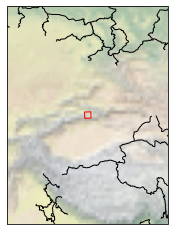

In [6]:
get_bbox(data_cube_x25_y475)

Now we can see where this granule lies. Let's try another url:

In [7]:
#this url doen'st work
url_x35_y305 = 's3://its-live-data/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X350000_Y3050000.zarr'
data_cube_x35_y305 = xr.open_dataset(url_x35_y305, engine= 'zarr',
                                    storage_options = {'anon':True})


/var/folders/rd/kx8trg7979q204t5141wt7_80000gn/T/ipykernel_2525/1036185922.py:3: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  data_cube_x35_y305 = xr.open_dataset(url_x35_y305, engine= 'zarr',


GroupNotFoundError: group not found at path ''

This link doesn't work. From the error we're getting, it looks like it's not working because the zarr file isn't in the location that we're pointing to with the url we supply. As cloud-based datasets are developed and maintained, the locations of specific objects will change and sometimes metadata doesn't always catch up, so this may be an error you'll encounter more than once. 

Let's try another url: 

In [ ]:
zarr_32645_x350000_y3050000 = 's3://its-live-data/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X350000_Y3050000.zarr'

ds_32645_x350000_y3050000 = xr.open_dataset(zarr_32645_x350000_y3050000, engine = 'zarr',
                            storage_options= {'anon':True})

We know that some zarr objects are located at the supplied urls but that some aren't. We have the entire catalog, but it sounds like a pain to look through each of those urls individually so let's write a method to find out which urls are working and which arent
- first, you want to save the its_live data cube catalog to your local machine (insert link)
- in the below cell, change the first line to contain the path to your catalog json object

In [8]:
with open('/Users/emmamarshall/Desktop/phd_research/siparcs/its_live_catalog_v02.json') as f:
    itslive_catalog = json.load(f)

In python, the json object is a number of nested dictionaries that contain information about all of the its_live datacubes. In this example, we're going to first select all of the granules within a single UTM zone (indicated by the CRS) and then take stock of the spatial coverage of the data cubes located at the **working** urls. You could easily tweak this function (or write your own!) to select granules based on different properties. Play around with the `itslive_catalog` object to become more familiar with the data it contains and different options for indexing.

In [20]:
def find_granules_by_epsg(input_dict, input_epsg):
    '''this function takes a dictionary that is a representation of itslive data cube geojson catalog as well as an 
    epsg code. it makes an intermediate object that is a list of all s3 urls for that utm region/epsg code. it
    then tried to open each zarr url as an xarray dataset and returns a list of the ones that are able to be opened
    successuflly (ie. the zarr file exists at the s3 url). each element of the return list is an xr dataset'''
    
    epsg_ls = []
        
    for granule in range(len(input_dict['features'])):
        
        if input_dict['features'][granule]['properties']['data_epsg'] == input_epsg:
            
            http_url = input_dict['features'][granule]['properties']['zarr_url']
            s3_url = http_url.replace('http', 's3')
            s3_url = s3_url.replace('.s3.amazonaws.com','')
            epsg_ls.append(s3_url)
     
    datacube_ls = []
    for element in range(len(epsg_ls)):
        try:
            datacube_ls.append(read_in_s3(epsg_ls[element]))
        except ValueError:
            print('nothing there ¯\_(ツ)_/¯ ')
            
    return datacube_ls
   

Here's a function to read in a zarr object stored at an s3 url as an xarray dataset:

In [21]:
def read_in_s3(http_url):
    s3_url = http_url.replace('http','s3')
    s3_url = s3_url.replace('.s3.amazonaws.com','')

    datacube = xr.open_dataset(s3_url, engine = 'zarr',
                                storage_options={'anon':True})

    return datacube

In [22]:
granule_ls_32645 = find_granules_by_epsg(itslive_catalog, 'EPSG:32645')
granule_ls_32645

s3://its-live-data/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X250000_Y3150000.zarr
s3://its-live-data/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X250000_Y3250000.zarr
s3://its-live-data/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X250000_Y3350000.zarr
s3://its-live-data/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X250000_Y3450000.zarr
s3://its-live-data/datacubes/v02/N40E080/ITS_LIVE_vel_EPSG32645_G0120_X250000_Y4650000.zarr
s3://its-live-data/datacubes/v02/N40E080/ITS_LIVE_vel_EPSG32645_G0120_X250000_Y4750000.zarr
s3://its-live-data/datacubes/v02/N40E080/ITS_LIVE_vel_EPSG32645_G0120_X250000_Y4850000.zarr
s3://its-live-data/datacubes/v02/N40E080/ITS_LIVE_vel_EPSG32645_G0120_X250000_Y4950000.zarr
s3://its-live-data/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X350000_Y3050000.zarr


/var/folders/rd/kx8trg7979q204t5141wt7_80000gn/T/ipykernel_2525/1591147121.py:6: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  datacube = xr.open_dataset(s3_url, engine = 'zarr',


nope
s3://its-live-data/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X350000_Y3150000.zarr
nope
s3://its-live-data/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X350000_Y3250000.zarr
nope
s3://its-live-data/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X350000_Y3350000.zarr
nope
s3://its-live-data/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X350000_Y4050000.zarr
s3://its-live-data/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X350000_Y4150000.zarr
s3://its-live-data/datacubes/v02/N40E080/ITS_LIVE_vel_EPSG32645_G0120_X350000_Y4650000.zarr
s3://its-live-data/datacubes/v02/N40E080/ITS_LIVE_vel_EPSG32645_G0120_X350000_Y4750000.zarr


/var/folders/rd/kx8trg7979q204t5141wt7_80000gn/T/ipykernel_2525/1591147121.py:6: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  datacube = xr.open_dataset(s3_url, engine = 'zarr',


nope
s3://its-live-data/datacubes/v02/N40E080/ITS_LIVE_vel_EPSG32645_G0120_X350000_Y4850000.zarr
nope
s3://its-live-data/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X450000_Y3050000.zarr
s3://its-live-data/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X450000_Y3150000.zarr
s3://its-live-data/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X450000_Y3250000.zarr
s3://its-live-data/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X450000_Y3350000.zarr
s3://its-live-data/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X450000_Y3450000.zarr
s3://its-live-data/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X450000_Y3950000.zarr
s3://its-live-data/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X450000_Y4050000.zarr
s3://its-live-data/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X450000_Y4150000.zarr
s3://its-live-data/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X450000_Y4250000.zarr
s3://its-live-data/datacubes/v02/N40E080/ITS_LIVE_vel_EPSG32645_G0120_

/var/folders/rd/kx8trg7979q204t5141wt7_80000gn/T/ipykernel_2525/1591147121.py:6: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  datacube = xr.open_dataset(s3_url, engine = 'zarr',


nope
s3://its-live-data/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X550000_Y3050000.zarr
s3://its-live-data/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X550000_Y3150000.zarr
s3://its-live-data/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X550000_Y3250000.zarr
s3://its-live-data/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X550000_Y3350000.zarr
s3://its-live-data/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X550000_Y3450000.zarr
s3://its-live-data/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X550000_Y3550000.zarr
s3://its-live-data/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X550000_Y3650000.zarr
s3://its-live-data/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X550000_Y3750000.zarr
s3://its-live-data/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X550000_Y3950000.zarr
s3://its-live-data/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X550000_Y4050000.zarr
s3://its-live-data/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X5500

/var/folders/rd/kx8trg7979q204t5141wt7_80000gn/T/ipykernel_2525/1591147121.py:6: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  datacube = xr.open_dataset(s3_url, engine = 'zarr',


nope
s3://its-live-data/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X650000_Y3150000.zarr
nope
s3://its-live-data/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X650000_Y3250000.zarr
s3://its-live-data/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X650000_Y3350000.zarr


/var/folders/rd/kx8trg7979q204t5141wt7_80000gn/T/ipykernel_2525/1591147121.py:6: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  datacube = xr.open_dataset(s3_url, engine = 'zarr',


nope
s3://its-live-data/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X650000_Y3450000.zarr
s3://its-live-data/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X650000_Y3550000.zarr
s3://its-live-data/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X650000_Y3650000.zarr
s3://its-live-data/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X650000_Y3750000.zarr


/var/folders/rd/kx8trg7979q204t5141wt7_80000gn/T/ipykernel_2525/1591147121.py:6: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  datacube = xr.open_dataset(s3_url, engine = 'zarr',


nope
s3://its-live-data/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X650000_Y3850000.zarr
s3://its-live-data/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X650000_Y3950000.zarr


/var/folders/rd/kx8trg7979q204t5141wt7_80000gn/T/ipykernel_2525/1591147121.py:6: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  datacube = xr.open_dataset(s3_url, engine = 'zarr',


nope
s3://its-live-data/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X650000_Y4050000.zarr
nope
s3://its-live-data/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X650000_Y4150000.zarr
s3://its-live-data/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X650000_Y4250000.zarr
s3://its-live-data/datacubes/v02/N40E080/ITS_LIVE_vel_EPSG32645_G0120_X650000_Y4750000.zarr
s3://its-live-data/datacubes/v02/N40E080/ITS_LIVE_vel_EPSG32645_G0120_X650000_Y4850000.zarr
s3://its-live-data/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X750000_Y3050000.zarr
s3://its-live-data/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X750000_Y3150000.zarr
s3://its-live-data/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X750000_Y3250000.zarr
s3://its-live-data/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X750000_Y3350000.zarr
s3://its-live-data/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_X750000_Y3750000.zarr
s3://its-live-data/datacubes/v02/N30E080/ITS_LIVE_vel_EPSG32645_G0120_

[<xarray.Dataset>
 Dimensions:                    (mid_date: 20549, y: 833, x: 833)
 Coordinates:
   * mid_date                   (mid_date) datetime64[ns] 2020-02-07T17:10:52....
   * x                          (x) float64 2.001e+05 2.002e+05 ... 2.999e+05
   * y                          (y) float64 3.2e+06 3.2e+06 ... 3.1e+06 3.1e+06
 Data variables: (12/54)
     acquisition_date_img1      (mid_date) datetime64[ns] ...
     acquisition_date_img2      (mid_date) datetime64[ns] ...
     autoRIFT_software_version  (mid_date) <U5 ...
     chip_size_height           (mid_date, y, x) float32 ...
     chip_size_width            (mid_date, y, x) float32 ...
     date_center                (mid_date) datetime64[ns] ...
     ...                         ...
     vy_error_mask              (mid_date) float64 ...
     vy_error_modeled           (mid_date) float64 ...
     vy_error_slow              (mid_date) float64 ...
     vy_stable_shift            (mid_date) float64 ...
     vy_stable_shift_

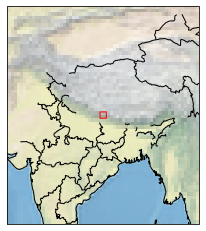

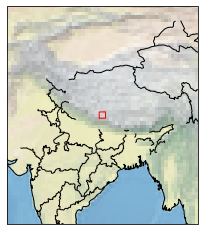

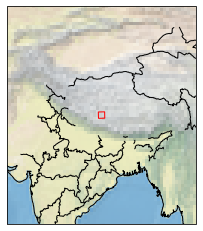

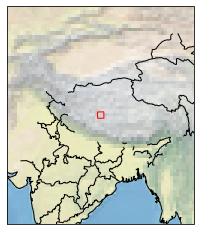

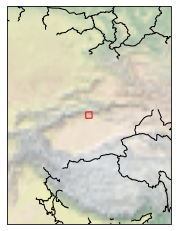

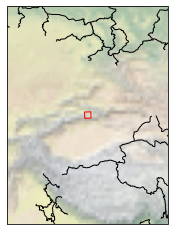

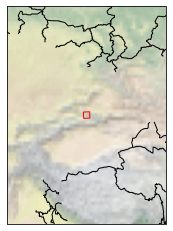

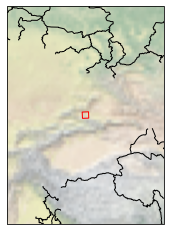

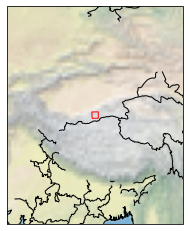

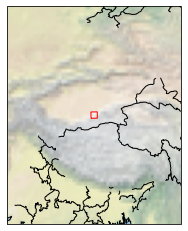

In [24]:
for element in range(len(granule_ls_32645))[:10]:
    get_bbox(granule_ls_32645[element])

## Function that we'll use later to see spatial extent of different zarr objects

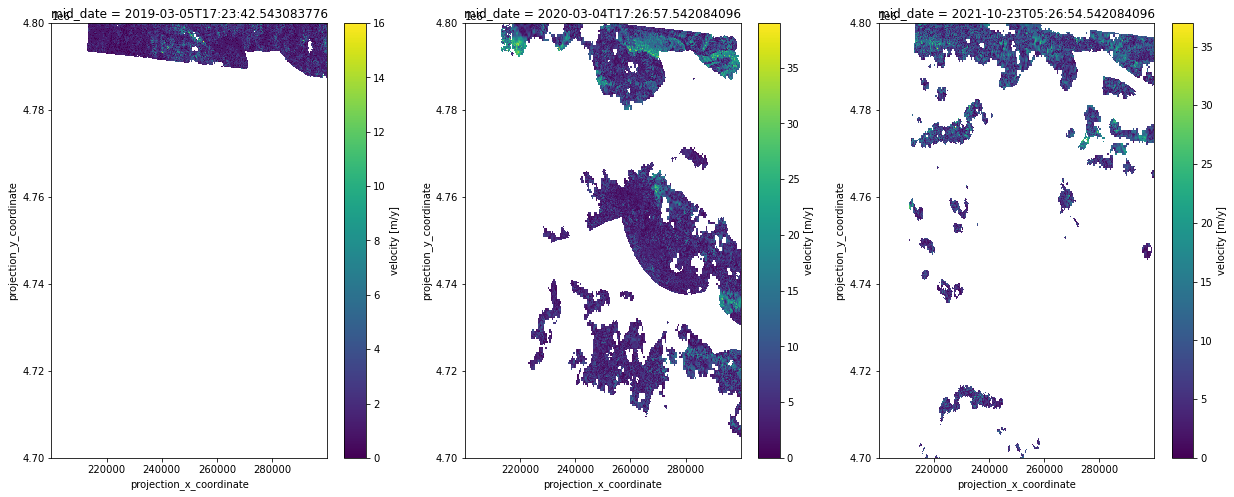

In [7]:
fig, axs = plt.subplots(ncols = 3, figsize=(21,8))
data_cube_x25_y475.isel(mid_date=1).v.plot(ax=axs[0])
data_cube_x25_y475.isel(mid_date=2).v.plot(ax=axs[1])
data_cube_x25_y475.isel(mid_date=3).v.plot(ax=axs[2])



Taking an initial look at a few different time steps, it looks like there is pretty variable coverage. Let's explore the variability in coverage a bit more: